In [ ]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

### Data preprocessing

In [ ]:
# Load dữ liệu
dataset = pd.read_csv(r'annonimized.csv')
df_th = pd.read_csv(r'th-public.csv')
df_qt = pd.read_csv(r'qt-public.csv')
df_ck = pd.read_csv(r'ck-public.csv')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295198 entries, 0 to 295197
Data columns (total 11 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   concat('it001',`assignment_id`)  295198 non-null  object
 1   concat('it001',`problem_id`)     295198 non-null  object
 2   concat('it001', username)        295198 non-null  object
 3   is_final                         295198 non-null  int64 
 4   status                           295198 non-null  object
 5   pre_score                        295198 non-null  int64 
 6   coefficient                      295198 non-null  int64 
 7   concat('it001',`language_id`)    295198 non-null  object
 8   created_at                       295198 non-null  object
 9   updated_at                       295198 non-null  object
 10  judgement                        295198 non-null  object
dtypes: int64(3), object(8)
memory usage: 24.8+ MB


In [ ]:
len(dataset)

135980

In [ ]:
# Loại bỏ kí tự đặc biệt và xử lý dữ liệu
def remove_special_char(dataset):
  dataset.iloc[:, 1] = dataset.iloc[:, 1].astype(str).str.replace('\xa0', '', regex=False).str.strip()
  for i in range(len(dataset)):
    if dataset.iloc[i, 1] == '':
      dataset.iloc[i, 1] = '0'
  dataset.iloc[:, 1] = dataset.iloc[:, 1].astype(str).astype(float)

  return dataset

# Chuyển đổi format dữ liệu và trích xuất dữ liệu
def parse_judgement(judgement_str):
  try:
      data = json.loads(judgement_str)
      total_tests = len(data.get('times', []))
      total_wrong = data.get('verdicts', {}).get('WRONG', 0)
      total_time = sum(data.get('times', []))
      total_mem = sum(data.get('mems', []))
      return pd.Series([total_tests, total_wrong, total_time, total_mem])
  except:
      return pd.Series([0, 0, 0, 0])

In [ ]:
df_th = remove_special_char(df_th)
df_qt = remove_special_char(df_qt)
df_ck = remove_special_char(df_ck)

df_qt['QT'] = df_qt['diemqt']
df_qt = df_qt.drop(columns=['diemqt'])

dataset[['total_tests', 'total_wrong', 'total_time', 'total_mem']] = dataset['judgement'].apply(parse_judgement)

/tmp/ipython-input-319-1610768804.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      5.5
1      6.5
2      4.5
3      5.0
4      4.0
      ... 
756    5.5
757    6.0
758    6.0
759    7.0
760    2.5
Name: CK, Length: 761, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.iloc[:, 1] = dataset.iloc[:, 1].astype(str).str.replace('\xa0', '', regex=False).str.strip()


In [ ]:
dataset.rename(columns={"concat('it001', username)": "hash", "concat('it001',`assignment_id`)": "assignment_id", "concat('it001',`problem_id`)": "problem_id"}, inplace=True)

In [ ]:
dataset

,assignment_id,problem_id,hash,is_final,status,pre_score,coefficient,"concat('it001',`language_id`)",created_at,updated_at,judgement,total_tests,total_wrong,total_time,total_mem
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",10.0,10.0,0.0,0.0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",10.0,10.0,0.0,0.0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",0.0,0.0,0.0,0.0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",0.0,0.0,0.0,0.0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",0.0,0.0,0.0,0.0
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,"{""times"":[],""mems"":[],""verdicts"":{""\n\nIn func...",0.0,0.0,0.0,0.0
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",0.0,0.0,0.0,0.0
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":[0...",0.0,0.0,0.0,0.0


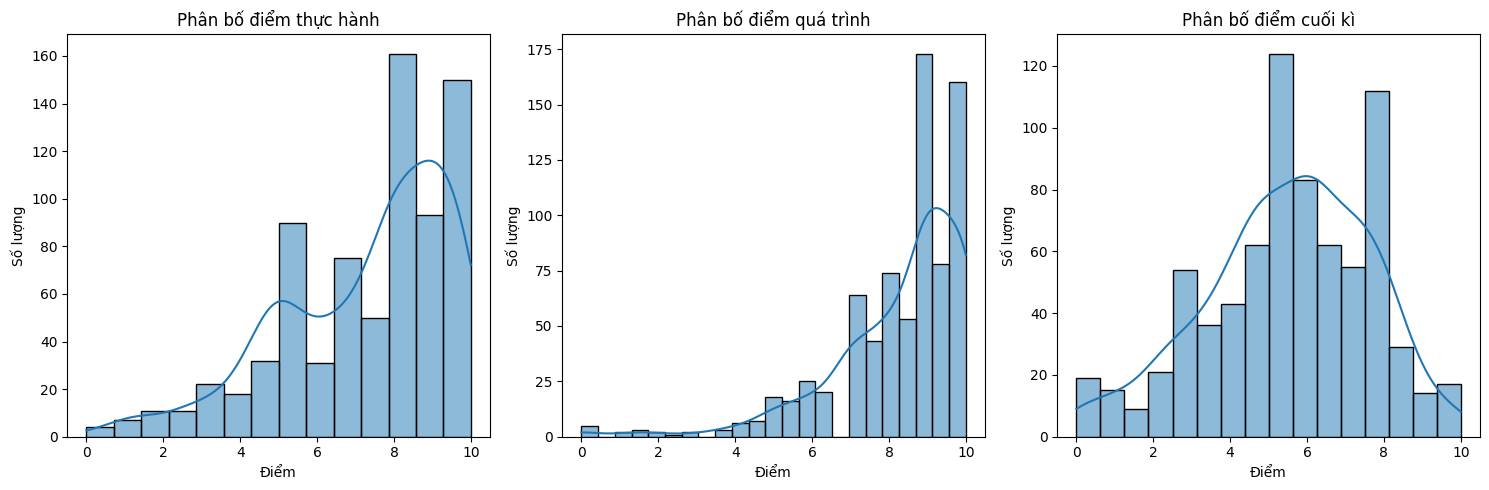

In [ ]:
# Biểu diễn phân bố của từng loại điểm
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_th['TH'], kde=True)
plt.title('Phân bố điểm thực hành')
plt.xlabel('Điểm')
plt.ylabel('Số lượng')

plt.subplot(1, 3, 2)
sns.histplot(df_qt['QT'], kde=True)
plt.title('Phân bố điểm quá trình')
plt.xlabel('Điểm')
plt.ylabel('Số lượng')

plt.subplot(1, 3, 3)
sns.histplot(df_ck['CK'], kde=True)
plt.title('Phân bố điểm cuối kì')
plt.xlabel('Điểm')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

In [ ]:
dataset['created_at'] = pd.to_datetime('2024-' + dataset['created_at'], errors='coerce')
dataset['updated_at'] = pd.to_datetime('2024-' + dataset['updated_at'], errors='coerce')

dataset['day'] = dataset['created_at'].dt.day

# Feature extraction

In [ ]:
# Trích xuất đặc trưng cho từng sinh viên để dự đoán điểm thực hành
agg_dt = dataset.groupby('hash').agg({
    'assignment_id': ['nunique', 'count'],
    'problem_id': 'nunique',
    'total_tests': 'sum',
    'total_wrong': 'sum',
    'day': 'nunique',
}).reset_index()

agg_dt.columns = [
    'hash',
    'num_assignments',
    'num_submissions',
    'num_problems',
    'tests_sum',
    'wrong_sum',
    'num_days'
]

In [ ]:
# Tính trung bình điểm pre_score cho các submission cuối cùng được chấm chính thức
final_score_mean = dataset[dataset['is_final'] == 1].groupby('hash')['pre_score'].mean().rename('final_pre_score_mean')
agg_dt = agg_dt.merge(final_score_mean, on='hash')

# Tỉ lệ test đúng trên số lượng test
agg_dt['accuracy'] = (agg_dt['tests_sum'] - agg_dt['wrong_sum']) / agg_dt['tests_sum']

In [ ]:
agg_dt.columns

Index(['hash', 'num_assignments', 'num_submissions', 'num_problems',
       'tests_sum', 'wrong_sum', 'num_days', 'final_pre_score_mean',
       'accuracy'],
      dtype='object')

### Huấn luyện và dự đoán để tìm điểm thực hành

In [ ]:
agg_df_th = agg_dt.copy()
agg_df_th = agg_df_th.drop(columns=['num_days', 'wrong_sum'])

In [ ]:
print(agg_df_th.columns)

Index(['hash', 'num_assignments', 'num_submissions', 'num_problems',
       'tests_sum', 'final_pre_score_mean', 'accuracy'],
      dtype='object')


In [ ]:
data = pd.merge(agg_df_th, df_th, on='hash')
data = data.dropna()

In [ ]:
# Tách dữ liệu
X_th = data.drop(columns=['hash', 'TH'])
y_th = data['TH']

In [ ]:
# Huấn luyện
X_train_th, X_val_th, y_train_th, y_val_th = train_test_split(X_th, y_th, train_size=0.7, random_state=42)

rf_th = RandomForestRegressor(random_state=42, n_estimators=400,
                              max_depth=7,
                              min_samples_split=5,
                              max_features=2,
                            )
rf_th.fit(X_train_th, y_train_th)

RandomForestRegressor(max_depth=7, max_features=2, min_samples_split=5,
                      n_estimators=400, random_state=42)

In [ ]:
# Đánh giá
y_pred_rf_th = rf_th.predict(X_val_th)

r2_rf_th = r2_score(y_val_th, y_pred_rf_th)
print(f"Random Forest R² score: {r2_rf_th:.4f}")

Random Forest R² score: 0.3631


In [ ]:
feature_importances_th = pd.DataFrame({'feature': X_th.columns, 'importance': rf_th.feature_importances_})
feature_importances_th = feature_importances_th.sort_values('importance', ascending=False)
feature_importances_th

,feature,importance
5,accuracy,0.260112
3,tests_sum,0.194668
2,num_problems,0.167074
1,num_submissions,0.149241
4,final_pre_score_mean,0.143449
0,num_assignments,0.085457


In [ ]:
xg_th = XGBRegressor(objective='reg:squarederror',
                    n_estimators=300,
                    learning_rate=0.01,
                    max_depth=3,
                    random_state=42,
                    verbosity=1
)

xg_th.fit(X_train_th, y_train_th,
          eval_set=[(X_val_th, y_val_th)],
          verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_xg_th = xg_th.predict(X_val_th)
r2_xg_th = r2_score(y_val_th, y_pred_xg_th)
print(f"XGBoost R² score: {r2_xg_th:.4f}")

XGBoost R² score: 0.3489


In [ ]:
feature_importances = pd.DataFrame({'feature': X_th.columns, 'importance': xg_th.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances

,feature,importance
5,accuracy,0.248647
2,num_problems,0.207544
3,tests_sum,0.170426
1,num_submissions,0.139929
4,final_pre_score_mean,0.136194
0,num_assignments,0.097260


In [ ]:
agg_df_th['TH_pred'] = rf_th.predict(agg_df_th.drop(columns=['hash']))
agg_df_th['TH_pred'] = agg_df_th['TH_pred'].round(2)

agg_df_th[['hash', 'TH_pred']].to_csv('submission_th_rfr.csv', index=False)

In [ ]:
# Dự đoán trên toàn bộ tập agg_df_th (không chứa cột hash và TH_pred)
agg_df_th['TH_pred_xg'] = xg_th.predict(agg_df_th.drop(columns=['hash', 'TH_pred']))
agg_df_th['TH_pred_xg'] = agg_df_th['TH_pred_xg'].round(2)

agg_df_th[['hash', 'TH_pred_xg']].to_csv('submission_th_xgboost.csv', index=False)

### Huấn luyện và dự đoán để tìm điểm quá trình

In [ ]:
agg_df_qt = agg_dt.copy()
agg_df_qt = agg_df_qt.drop(columns=['wrong_sum', 'accuracy'])

In [ ]:
len(agg_df_qt.columns)

7

In [ ]:
#  Gộp QT vào bảng đặc trưng
data_qt = pd.merge(agg_df_qt, df_qt, on='hash')
data_qt = data_qt.dropna()

#  Tách đặc trưng & nhãn
X_qt = data_qt.drop(columns=['hash', 'QT'])
y_qt = data_qt['QT']

In [ ]:
# Huấn luyện mô hình
X_train_qt, X_val_qt, y_train_qt, y_val_qt = train_test_split(X_qt, y_qt, train_size=0.7, random_state=42)
model_qt = RandomForestRegressor(random_state=42, n_estimators=50,
                                 max_depth=5,
                                 min_samples_split=5,
                                 max_features=2,
                              )
model_qt.fit(X_train_qt, y_train_qt)

#  Đánh giá
y_pred_qt = model_qt.predict(X_val_qt)
r2_qt = r2_score(y_val_qt, y_pred_qt)
print(f"R² score: {r2_qt:.4f}")

R² score: 0.0823


In [ ]:
feature_importances_qt = pd.DataFrame({'feature': X_qt.columns, 'importance': model_qt.feature_importances_})
feature_importances_qt = feature_importances_qt.sort_values('importance', ascending=False)
feature_importances_qt

,feature,importance
3,tests_sum,0.222360
1,num_submissions,0.193530
2,num_problems,0.177624
5,final_pre_score_mean,0.174169
0,num_assignments,0.140314
4,num_days,0.092004


In [ ]:
xg_qt = XGBRegressor(objective='reg:squarederror',
                    n_estimators=300,
                    learning_rate=0.01,
                    max_depth=4,
                    random_state=42,
                    verbosity=1
)

xg_qt.fit(X_train_qt, y_train_qt,
          eval_set=[(X_val_qt, y_val_qt)],
          verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_xg_qt = xg_qt.predict(X_val_qt)
r2_xg_qt = r2_score(y_val_qt, y_pred_xg_qt)
print(f"XGBoost R² score: {r2_xg_qt:.4f}")

XGBoost R² score: 0.0985


In [ ]:
agg_df_qt['QT_pred'] = model_qt.predict((agg_df_qt).drop(columns=['hash']))
agg_df_qt['QT_pred'] = agg_df_qt['QT_pred'].round(2)  # Làm tròn đến 2 chữ số thập phân

agg_df_qt[['hash', 'QT_pred']].to_csv('submission_qt_rfr.csv', index=False)

### Huấn luyện và dự đoán để tìm điểm cuối kỳ

In [ ]:
agg_df_ck = agg_dt.copy()

In [ ]:
len(agg_df_ck.columns)

8

In [ ]:
#  Gộp CK vào bảng đặc trưng
data_ck = pd.merge(agg_df_ck, df_ck, on='hash')
data_ck = data_ck.dropna()

#  Tách đặc trưng & nhãn
X_ck = data_ck.drop(columns=['hash', 'CK'])
y_ck = data_ck['CK']

#  Huấn luyện mô hình
X_train_ck, X_val_ck, y_train_ck, y_val_ck = train_test_split(X_ck, y_ck, train_size=0.7, random_state=42)
model_ck = RandomForestRegressor(random_state=42, n_estimators=400,
                                 max_depth=10,
                                 min_samples_split=5,
                                 max_features=2,
                                 )
model_ck.fit(X_train_ck, y_train_ck)

#  Đánh giá
y_pred_ck = model_ck.predict(X_val_ck)
r2_ck = r2_score(y_val_ck, y_pred_ck)
print(f"R² score CK: {r2_ck:.4f}")

R² score CK: 0.3513


In [ ]:
feature_importances_ck = pd.DataFrame({'feature': X_ck.columns, 'importance': model_ck.feature_importances_})
feature_importances_ck = feature_importances_ck.sort_values('importance', ascending=False)
feature_importances_ck

,feature,importance
7,accuracy,0.335547
3,tests_sum,0.146343
1,num_submissions,0.111448
4,wrong_sum,0.106178
2,num_problems,0.092456
6,final_pre_score_mean,0.087183
0,num_assignments,0.066617
5,num_days,0.054228


In [ ]:
xg_ck = XGBRegressor(objective='reg:squarederror',
                    n_estimators=300,
                    learning_rate=0.05,
                    max_depth=4,
                    random_state=42,
                    verbosity=1
)

xg_ck.fit(X_train_ck, y_train_ck,
          eval_set=[(X_val_ck, y_val_ck)],
          verbose=False
)

xg_pred_ck = xg_ck.predict(X_val_ck)
r2_xg_ck = r2_score(y_val_ck, xg_pred_ck)
print(f"XGBoost R² score: {r2_xg_ck:.4f}")

XGBoost R² score: 0.3312


In [ ]:
#  đoán và lưu file
agg_df_ck['CK_pred'] = model_ck.predict(agg_df_ck.drop(columns=['hash']))
agg_df_ck['CK_pred'] = agg_df_ck['CK_pred'].round(2)

agg_df_ck[['hash', 'CK_pred']].to_csv('submission_ck_rfr.csv', index=False)

### Huấn luyện và dự đoán để tìm điểm TBTL

In [ ]:
df_tbtl = pd.merge(df_th, df_qt, on='hash')
df_tbtl = pd.merge(df_tbtl, df_ck, on='hash')
df_tbtl['TBTL'] = df_tbtl['TH'] * 0.3 + df_tbtl['QT'] * 0.3 + df_tbtl['CK'] * 0.4
df_tbtl['TBTL'] = df_tbtl['TBTL'].round(2)

In [ ]:
df_tbtl

,hash,TH,QT,CK,TBTL
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.0,7.5,5.5,5.95
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.5,7.0,6.5,7.25
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7.0,9.0,4.5,6.6
3,013de369c439ab0ead8aa7da64423aa395a8be39,10.0,10.0,5.0,8.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,6.0,9.0,4.0,6.1
...,...,...,...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,6.0,9.0,5.5,6.7
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,8.5,8.0,6.0,7.35
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,5.5,6.5,6.0,6.0
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,10.0,10.0,7.0,8.8


In [ ]:
df_tbtl.drop(columns=['TH', 'QT', 'CK'], inplace=True)

In [ ]:
df_tbtl

,hash,TBTL
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.95
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7.25
2,01122b3ef7e59b84189e65985305f575d6bdf83c,6.6
3,013de369c439ab0ead8aa7da64423aa395a8be39,8.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,6.1
...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,6.7
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,7.35
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,6.0
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,8.8


In [ ]:
agg_df_tb = agg_dt.copy()

In [ ]:
len(agg_df_tb.columns)

9

In [ ]:
#  Gộp CK vào bảng đặc trưng
data_tb = pd.merge(agg_df_tb, df_tbtl, on='hash')
data_tb = data_tb.dropna()

#  Tách đặc trưng & nhãn
X_tb = data_tb.drop(columns=['hash', 'TBTL'])
y_tb = data_tb['TBTL']

#  Huấn luyện mô hình
X_train_tb, X_val_tb, y_train_tb, y_val_tb = train_test_split(X_tb, y_tb, random_state=42)
model_tb = RandomForestRegressor(random_state=42, n_estimators=400,
                                 max_depth=5,
                                 min_samples_split=5,
                                 max_features=4,
                                 )
model_tb.fit(X_train_tb, y_train_tb)

#  Đánh giá
y_pred_tb = model_tb.predict(X_val_tb)
r2_tb= r2_score(y_val_tb, y_pred_tb)
print(f"R² score TBTL: {r2_tb:.4f}")

R² score TBTL: 0.3188


In [ ]:
feature_importances_tb = pd.DataFrame({'feature': X_tb.columns, 'importance': model_tb.feature_importances_})
feature_importances_tb = feature_importances_tb.sort_values('importance', ascending=False)
feature_importances_tb

,feature,importance
7,accuracy,0.305259
3,tests_sum,0.149200
4,wrong_sum,0.127858
2,num_problems,0.112504
6,final_pre_score_mean,0.095495
1,num_submissions,0.092761
5,num_days,0.061204
0,num_assignments,0.055718


In [ ]:
xg_tb = XGBRegressor(objective='reg:squarederror',
                    n_estimators=500,
                    learning_rate=0.01,
                    max_depth=5,
                    verbosity=1
)

xg_tb.fit(X_train_tb, y_train_tb,
          eval_set=[(X_val_tb, y_val_tb)],
          verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xg_tb_pred = xg_tb.predict(X_val_tb)
r2_xg_tb = r2_score(y_val_tb, xg_tb_pred)
print(f"XGBoost R² score: {r2_xg_tb:.4f}")

XGBoost R² score: 0.3067


In [ ]:
# Dự đoán và lưu file
agg_df_tb['TBTL_pred'] = model_tb.predict(agg_df_tb.drop(columns=['hash']))
agg_df_tb['TBTL_pred'] = agg_df_tb['TBTL_pred'].round(2)  # Làm tròn đến 2 chữ số thập phân

agg_df_tb[['hash', 'TBTL_pred']].to_csv('submission_tbtl_rfr.csv', index=False)